<a href="https://colab.research.google.com/github/jack-baxter/AAI521-G6-Final/blob/main/copy_of_Group6_project_ORG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br><center>AAI-521 Final Project
<br><center>Solar Panel Defect Detection
<br><center>Group 6
<br><center>Fall 2025, Dr. Albuyeh
<br><center>Jamshed Nabizada, Jack Baxter, Naima Botros

# Library Imports and Dependency Setup

In [ ]:
!pip install torch torchvision torchaudio pandas numpy scikit-learn matplotlib seaborn Pillow

In [45]:
#import necessary libraries
#google colab and files
# google colab
from google.colab import drive
import os
import shutil
import time
import tempfile

# data
import pandas as pd
import numpy as np

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# image proc
from PIL import Image

# scikit-learn
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

# util
from tqdm import tqdm
from collections import defaultdict

# Mount Google Drive

In [5]:
#mount and path
drive.mount('/content/drive')
print("Environment ready.")
BASE_DIR = "/content/drive/MyDrive/ELPV_SOLAR_DATA/"
if not os.path.exists(BASE_DIR):
    raise FileNotFoundError("BASE_DIR does not exist. Verify your Google Drive path.")
print("BASE_DIR:", BASE_DIR)


Mounted at /content/drive
Environment ready.
BASE_DIR: /content/drive/MyDrive/ELPV_SOLAR_DATA/


In [6]:
#local data copy
print("Starting local data copy...")
start_time = time.time()

#destination
LOCAL_DIR = "/content/ELPV_SOLAR_DATA/"

#recursive data copy
shutil.copytree(BASE_DIR, LOCAL_DIR)
print(f"Copy complete in {time.time() - start_time:.2f} seconds.")

#update base dir
BASE_DIR = LOCAL_DIR
print("BASE_DIR updated to local path:", BASE_DIR)

Starting local data copy...
Copy complete in 602.39 seconds.
BASE_DIR updated to local path: /content/ELPV_SOLAR_DATA/


# Data Parsing, DataFrame Construction and Initial Counts

In [7]:
#function to parse binary labels from set
def parse_binary_label(txt_path):
    """
    Converts YOLO labels into a binary classification target:
    - 1 = defective (any YOLO class present)
    - 0 = non-defective (no class entries or missing file)
    """
    if not os.path.exists(txt_path):
        return 0

    with open(txt_path, "r") as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip()]

    return 1 if len(lines) > 0 else 0

#function to build dataframe
def build_dataframe(root_dir):
    data = []

    for split in ["train", "valid", "test"]:
        img_dir = os.path.join(root_dir, split, "images")
        lbl_dir = os.path.join(root_dir, split, "labels")

        if not os.path.isdir(img_dir):
            continue

        for img_name in os.listdir(img_dir):
            name, ext = os.path.splitext(img_name)
            if ext.lower() not in [".jpg", ".jpeg", ".png"]:
                continue

            img_path = os.path.join(img_dir, img_name)
            txt_path = os.path.join(lbl_dir, name + ".txt")
            label = parse_binary_label(txt_path)

            data.append({
                "image_path": img_path,
                "label": label
            })

    df = pd.DataFrame(data)
    return df

#build frame
df_full = build_dataframe(BASE_DIR)

if df_full.empty:
    raise SystemExit("No images found. Check dataset structure.")

print("Total images:", len(df_full))
print(df_full.head())

print("\nClass distribution:")
print(df_full['label'].value_counts())


Total images: 7435
                                          image_path  label
0  /content/ELPV_SOLAR_DATA/train/images/DJI_2022...      1
1  /content/ELPV_SOLAR_DATA/train/images/DJI_0555...      1
2  /content/ELPV_SOLAR_DATA/train/images/zbc101IR...      0
3  /content/ELPV_SOLAR_DATA/train/images/210915_H...      1
4  /content/ELPV_SOLAR_DATA/train/images/DJI_0196...      1

Class distribution:
label
1    7332
0     103
Name: count, dtype: int64


- The function: parse_binary_label reads YOLO .txt files: returns 1 if any defect, 0 otherwise.
- The function: build_dataframe scans train/valid/test folders, builds DataFrame with image_path and label.
- Output prints total number of images and counts per class.

# Exploratory Data Analysis (EDA\)

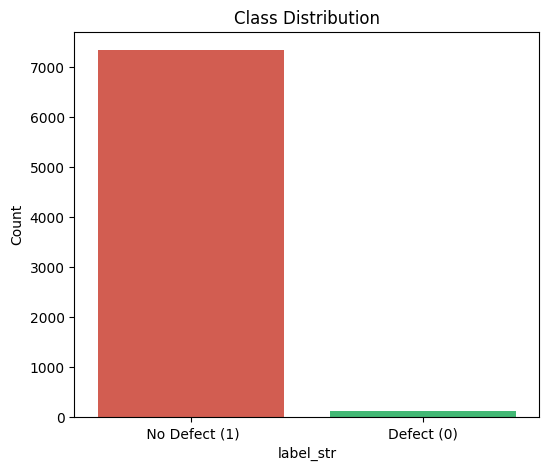

In [51]:
#map labels for visuals and output
df_full["label_str"] = df_full["label"].map({0: "Defect (0)", 1: " No Defect (1)"})

plt.figure(figsize=(6,5))
sns.countplot(
    x="label_str",
    data=df_full,
    hue="label_str",
    palette={"Defect (0)": "#2ecc71", " No Defect (1)": "#e74c3c"},
    legend=False
)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()


- Maps numeric labels to descriptive strings.
- Removes hue to avoid doubling bars and misrepresentation.
- Ensures the plot correctly shows majority class (1) as expected.

# Split dataset into train/val/test

In [9]:
#80/10/10 train test validation split
df_train, df_temp = train_test_split(
    df_full, test_size=0.20, stratify=df_full["label"], random_state=42
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.50, stratify=df_temp["label"], random_state=42
)

print("Split sizes:")
print("Train:", len(df_train))
print("Val:  ", len(df_val))
print("Test: ", len(df_test))


Split sizes:
Train: 5948
Val:   743
Test:  744


- Splits dataset while preserving class ratios (stratify).
- Ensures roughly 80% train, 10% validation, 10% test.

# Visual Inspection of Sample Training Images

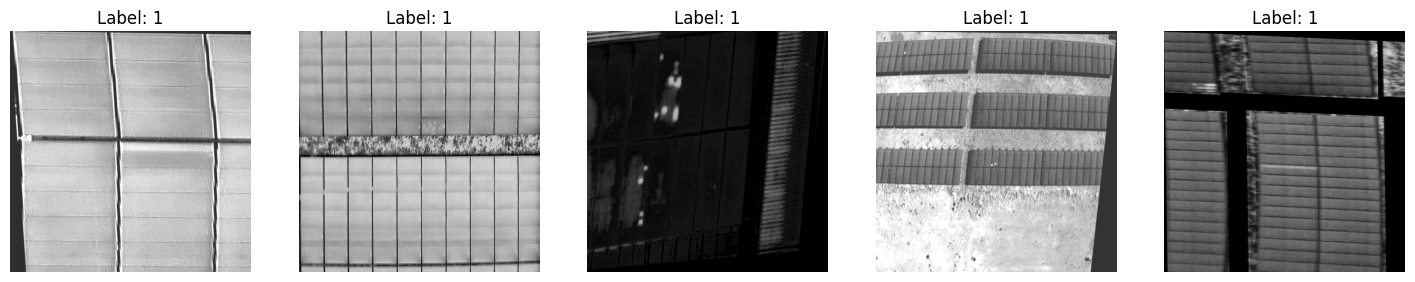

In [10]:
#function to show samples of training data
def show_samples(df, n=5):
    samples = df.sample(n, random_state=42)
    fig, axes = plt.subplots(1, n, figsize=(18, 5))

    for i, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row["image_path"]).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {row['label']}")
        axes[i].axis("off")

    plt.show()

show_samples(df_train, n=5)


- Displays random sample images from the training set.
- Helps visually confirm label correctness.

# Data Processing and Augmentation Pipelines

In [11]:
image_size = 256
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    # enhancement: Added RandomAffine for geometric augmentation (slight shifts, zooms, and rotation).
    # This simulates minor changes in camera angle or panel mounting.
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    # Standard ImageNet normalization for transfer learning
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

- Defines image preprocessing and augmentation for train/validation/test sets.
- Training includes flips, rotation, color jitter; test/validation only resize & normalize.

# Dataset and DataLoader

In [12]:
#create class for PVPpaneldataset
class PVPanelDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row["label"], dtype=torch.long)
        return img, label

#create function to collate and remove none values
def collate_remove_none(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)


batch_size = 32
num_workers = 2

train_loader = DataLoader(PVPanelDataset(df_train, train_transform),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, collate_fn=collate_remove_none)

val_loader = DataLoader(PVPanelDataset(df_val, test_transform),
                        batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, collate_fn=collate_remove_none)

test_loader = DataLoader(PVPanelDataset(df_test, test_transform),
                         batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, collate_fn=collate_remove_none)

print("Dataloaders ready.")


Dataloaders ready.


- The function: PVPanelDataset loads images and labels from a DataFrame.
- The function: collate_remove_none avoids errors if any images are missing.
- DataLoaders are ready for training and evaluation.

#ResNet 18 Initialization

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#function to initialize resnet18 model
def initialize_resnet18(num_class=2, freeze=True):
  weights = ResNet18_Weights.IMAGENET1K_V1
  model = resnet18(weights=weights)

  if freeze:
    for p in model.parameters():
      p.requires_grad = False

  model.fc = nn.Linear(model.fc.in_features, num_class)
  return model.to(device)
model = initialize_resnet18()
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- Load a pretrained ResNet-18 model with ImageNet weights
- Freez all layers then replaces the final FC layer to match the number of classes

# Class Weight Calculation

In [14]:
#get counts, major and minor and print weights
counts = df_full["label"].value_counts()
minority = counts.get(0,1)
majority = counts.get(1,1)

weight_for_0 = majority / minority
weight_for_1 = 1.0

class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float).to(device)
print("Class wieghts", class_weights)

Class wieghts tensor([71.1845,  1.0000], device='cuda:0')


- Computing how many samples belong to each class (0,1)
- Creates a higher weight for the minority class so the loss function penalizes misclasification of that class more strongly


# Baseline CNN Model

In [15]:
# baseline CNN model with four convolutional layers
# max pooling after each pair
# dropout for regularization
# and two fully connected layers for classification
class BaselineCNN(nn.Module):

    # function to initialize all convolutional, pooling, dropout,
    # and fully connected layers
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()

        # first convolution block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # second convolution block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # regularization
        self.dropout = nn.Dropout(0.3)

        # fully connected layers
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    # function to define forward pass
    def forward(self, x):

        # conv blocks
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # flatten feature maps
        x = x.view(x.size(0), -1)

        # fully connected classifier
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)

        return x


# Initialize Baseline CNN

In [16]:
# running this to ensure we are running GPU for training
# as runtime can be long
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize the baseline model, and move it to the selected device (GPU)
baseline_model = BaselineCNN(num_classes=2).to(device)
print(baseline_model) # print model architecture


BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


#Training and Validation

In [17]:
# function to train our model
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=0.001,
    class_weights=None
):

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # track loss and accuracy across epich
    history = {"train_loss": [],
               "val_loss": [],
               "train_acc": [],
               "val_acc": []
              }

    # iterate trhough epochs for training
    for epoch in range(num_epochs):
        model.train() # set the model to training mode
        running_loss = 0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        # our training loop
        for images, labels in loop:

            # move input images and labels to our device (GPU)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # reset gradients
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels)
            loss.backward() # backdrop
            optimizer.step() # update weights

            # accumulate total loss for the epoch
            running_loss += loss.item() * images.size(0)

            # compute our training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # validation loop
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        # no gradient updates during validation,
        # disables backdrop to speed up inference
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # compute average validation loss and overall validation accuracy
        val_loss /= val_total
        val_acc = val_correct / val_total

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history

# Model Training

In [18]:
# train our model
history_baseline = train_model(
    baseline_model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=0.0005,
    class_weights=class_weights
)


Epoch 1/10: 100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


Epoch 1 | Train Acc: 0.9860 | Val Acc: 0.9865


Epoch 2/10: 100%|██████████| 186/186 [01:02<00:00,  2.98it/s]


Epoch 2 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 3/10: 100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


Epoch 3 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 4/10: 100%|██████████| 186/186 [01:04<00:00,  2.89it/s]


Epoch 4 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 5/10: 100%|██████████| 186/186 [01:04<00:00,  2.87it/s]


Epoch 5 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 6/10: 100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


Epoch 6 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 7/10: 100%|██████████| 186/186 [01:02<00:00,  2.98it/s]


Epoch 7 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 8/10: 100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


Epoch 8 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 9/10: 100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


Epoch 9 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 10/10: 100%|██████████| 186/186 [01:04<00:00,  2.88it/s]


Epoch 10 | Train Acc: 0.9862 | Val Acc: 0.9865


# Prediction Collection Function for Evaluation

In [20]:
# this function is to run the model in evaluation mode
# and collect all predicitions that are true labels
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad(): # disable gradients for faster inference
        for images, labels in loader:
            images = images.to(device) # move batch to device
            outputs = model(images) # forward pass
            _, preds = outputs.max(1) # get predicted class indices

            # convert tensors to numpy arrays (required for metrics)
            # and store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)


# Compute Classification Metrics and Confusion Matrix

In [21]:
# get all true labels and model predictions from the test set
y_true, y_pred = get_predictions(baseline_model, test_loader)

# generate/print precision, recall, F1 scores for each class
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["Healthy", "Defect"],
    # FIX: Explicitly set zero_division=0 to suppress the warning
    zero_division=0
))

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm # call to display CM

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        11
      Defect       0.99      1.00      0.99       733

    accuracy                           0.99       744
   macro avg       0.49      0.50      0.50       744
weighted avg       0.97      0.99      0.98       744



array([[  0,  11],
       [  0, 733]])

# Visualize Confusion Matrix (Heatmap)

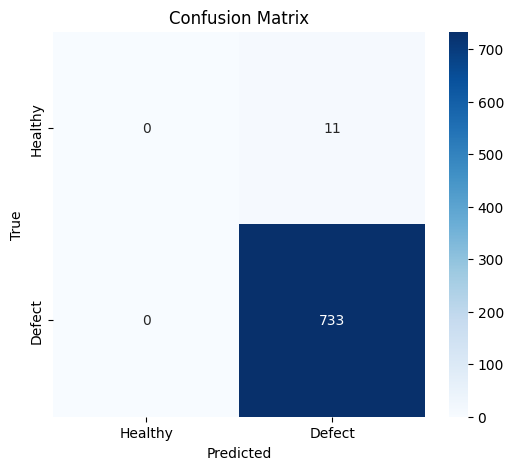

In [22]:
# plot our confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Defect"],
            yticklabels=["Healthy", "Defect"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Visualization Function: Show Misclassified Samples

In [23]:
# this function will display the sample images the model misclassified
def show_incorrect_predictions(model, loader, num_images=10):
    model.eval()

    # mean and standard deviation tensors to reverse image
    # normalization for proper display
    mean_t = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std_t = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    incorrect_images_list = [] # list to contain the incorrect images

    # run inference without gradients, collect misclassified image
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(next(model.parameters()).device) # move to device
            labels = labels.to(next(model.parameters()).device)

            outputs = model(imgs) # forward pass
            _, preds = torch.max(outputs, 1) # predicted class indices

            # store incorrect predictions untl the limit is reached
            for img, label, pred in zip(imgs, labels, preds):
                if label != pred:
                    incorrect_images_list.append((
                        img.cpu(),
                        label.item(),
                        pred.item())
                    )

                    if len(incorrect_images_list) >= num_images:
                        break

            if len(incorrect_images_list) >= num_images:
                break

    # set image plot size
    fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3))

    # plot incorrect images
    for ax, (img, true_label, pred_label) in zip(axes, incorrect_images_list):
        img_denorm = img * std_t + mean_t
        img_disp = img_denorm.permute(1, 2, 0).numpy()

        ax.imshow(img_disp)
        ax.axis("off")
        ax.set_title(f"T:{true_label}, P:{pred_label}", fontsize=10)

    plt.show()


# Display Incorrect Test Predictions

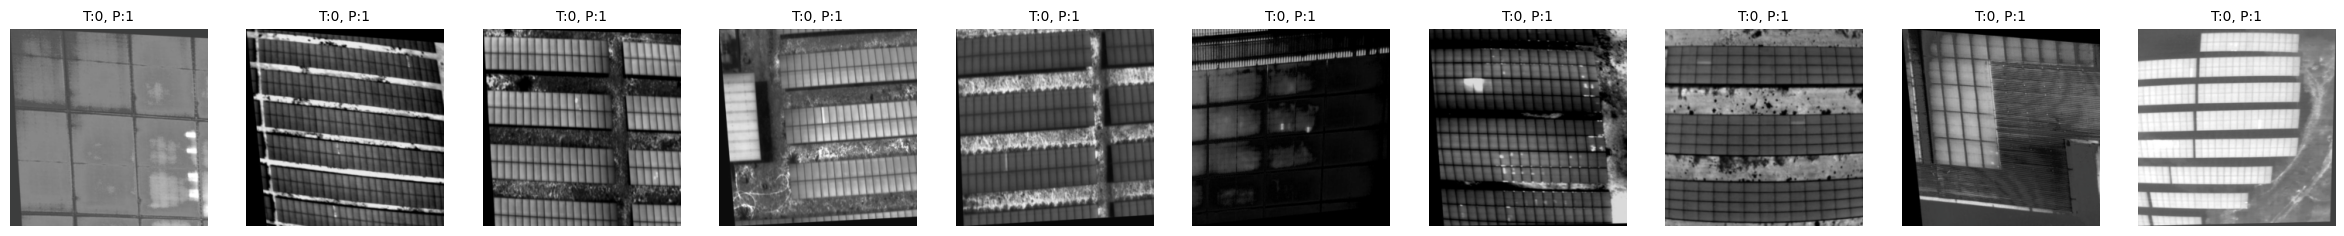

In [24]:
show_incorrect_predictions(baseline_model, test_loader)

# Visualization Function: Show Correctly Classified Samples

In [25]:
# this function will display the sample images the model classified correctly
def show_correct_predictions(model, loader, num_images=10):
    model.eval()

    # ImageNet normalization values (ResNet18 default)
    mean_t = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std_t = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    correct_images = 0
    correct_images_list = []

    # run inference without gradients, collect correctly classified images
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)

            outputs = model(imgs) # forward pass
            _, preds = torch.max(outputs, 1) # predicted class indices

            # store correct predictions until the limit is reached
            for img, label, pred in zip(imgs, labels, preds):
                if label == pred:  # correct prediction
                    img = img.cpu()
                    correct_images_list.append((
                        img,
                        label.item(),
                        pred.item())
                    )

                    correct_images += 1
                    if correct_images >= num_images:
                        break

            if correct_images >= num_images:
                break

    # set image plot size
    fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3))

    # plot correct images
    for ax, (img, true_label, pred_label) in zip(axes, correct_images_list):
        img_denorm = img * std_t + mean_t
        img_disp = img_denorm.permute(1, 2, 0).numpy()

        ax.imshow(img_disp)
        ax.axis("off")
        ax.set_title(f"Correct: {true_label}", fontsize=10)

    plt.show()


# Display Correct Test Predictions

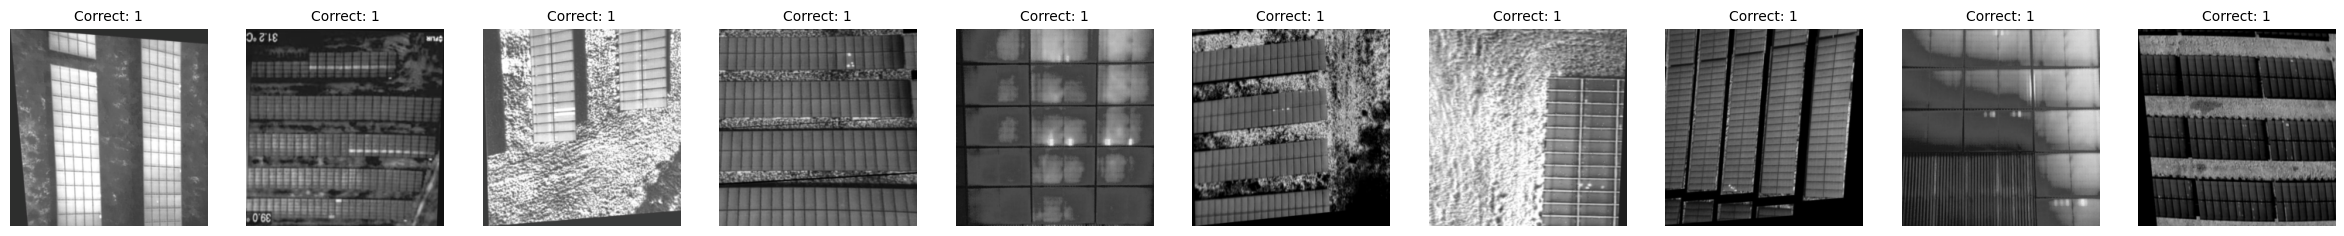

In [26]:
show_correct_predictions(baseline_model, test_loader)

# Evaluation Function: Plot ROC Curve and AUC



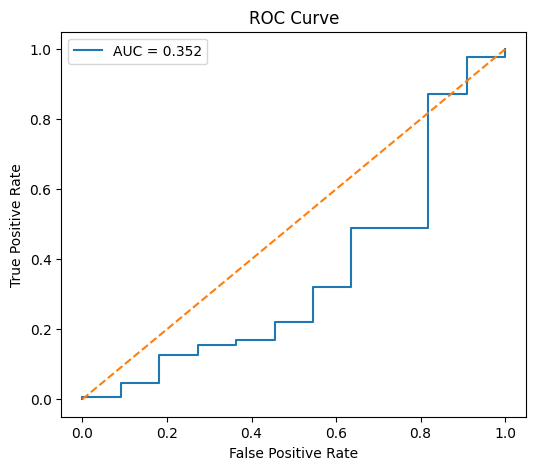

In [27]:
# function to plot ROC curve
def plot_roc(model, loader):
    model.eval()
    probs = []
    labels = []

    with torch.no_grad(): # disable gradients for faster inference
        for images, lbls in loader:
            images = images.to(device) # move to device
            outputs = model(images) # forward pass

            # compute softmax probabilities
            softmax = torch.softmax(outputs, dim=1)
            probs.extend(softmax[:,1].cpu().numpy())  # probability of class 1
            labels.extend(lbls.numpy())

    # compute ROC curve points and area under the curve
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    # plot our ROC curve
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

plot_roc(baseline_model, test_loader)

### Training Curves (Accuracy & Loss)

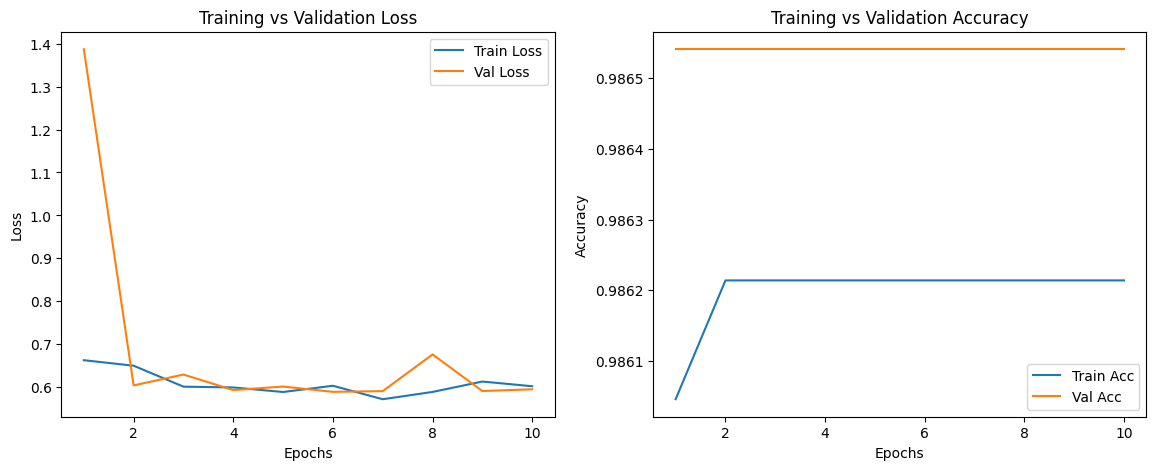

In [28]:
# function to plot loss and accuracy curves
def plot_training_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14,5))

    # loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label='Train Acc')
    plt.plot(epochs, history["val_acc"], label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.show()

# call our loss/accuracy plot function
plot_training_curves(history_baseline)


### Train ResNet18 Model

In [29]:
# initialize ResNet18 model
resnet18_model = initialize_resnet18(num_class=2, freeze=True)

# train ResNet18 model
history_resnet = train_model(
    resnet18_model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=0.0005,
    class_weights=class_weights
)


Epoch 1/10: 100%|██████████| 186/186 [01:00<00:00,  3.05it/s]


Epoch 1 | Train Acc: 0.8979 | Val Acc: 0.9381


Epoch 2/10: 100%|██████████| 186/186 [01:01<00:00,  3.00it/s]


Epoch 2 | Train Acc: 0.8653 | Val Acc: 0.9865


Epoch 3/10: 100%|██████████| 186/186 [01:01<00:00,  3.03it/s]


Epoch 3 | Train Acc: 0.9217 | Val Acc: 0.9771


Epoch 4/10: 100%|██████████| 186/186 [01:01<00:00,  3.04it/s]


Epoch 4 | Train Acc: 0.9420 | Val Acc: 0.5962


Epoch 5/10: 100%|██████████| 186/186 [01:01<00:00,  3.00it/s]


Epoch 5 | Train Acc: 0.9050 | Val Acc: 0.9825


Epoch 6/10: 100%|██████████| 186/186 [01:03<00:00,  2.94it/s]


Epoch 6 | Train Acc: 0.8996 | Val Acc: 0.8452


Epoch 7/10: 100%|██████████| 186/186 [01:01<00:00,  3.04it/s]


Epoch 7 | Train Acc: 0.9457 | Val Acc: 0.9865


Epoch 8/10: 100%|██████████| 186/186 [01:01<00:00,  3.04it/s]


Epoch 8 | Train Acc: 0.9265 | Val Acc: 0.9865


Epoch 9/10: 100%|██████████| 186/186 [01:02<00:00,  2.96it/s]


Epoch 9 | Train Acc: 0.9336 | Val Acc: 0.9865


Epoch 10/10: 100%|██████████| 186/186 [01:00<00:00,  3.05it/s]


Epoch 10 | Train Acc: 0.9255 | Val Acc: 0.9865


ResNet18 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        11
      Defect       0.99      1.00      0.99       733

    accuracy                           0.99       744
   macro avg       0.49      0.50      0.50       744
weighted avg       0.97      0.99      0.98       744



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


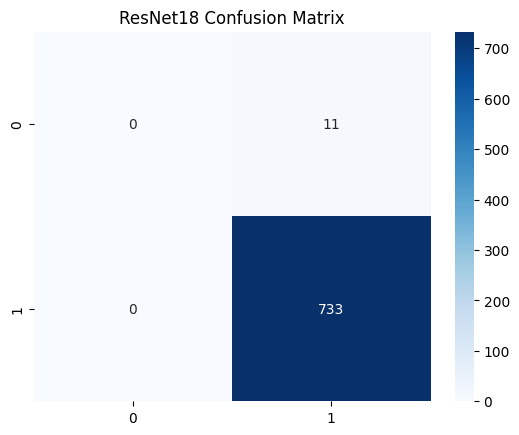

In [30]:
# get true/predicted labels for the ResNet18 model on the test set
y_true_res, y_pred_res = get_predictions(resnet18_model, test_loader)

# display full classification metrics for the ResNet18 model
print("ResNet18 Classification Report:")
print(classification_report(
    y_true_res,
    y_pred_res,
    target_names=["Healthy", "Defect"])
)

# plot confusion matrix
cm_res = confusion_matrix(y_true_res, y_pred_res)
sns.heatmap(cm_res, annot=True, fmt='d', cmap='Blues')
plt.title("ResNet18 Confusion Matrix")
plt.show()


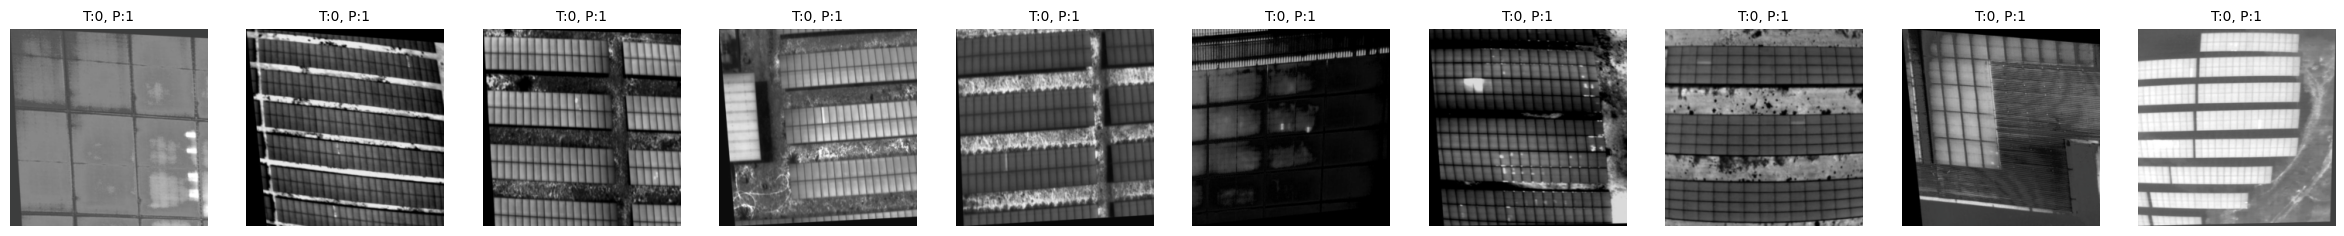

In [31]:
# call incorrect predictions function
show_incorrect_predictions(resnet18_model, test_loader)

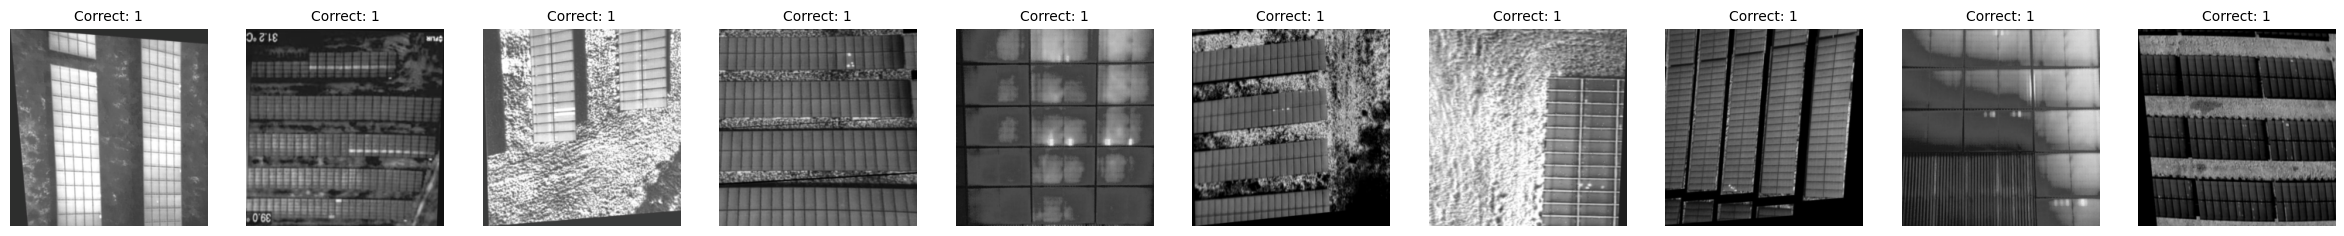

In [32]:
# call correct predictions function
show_correct_predictions(resnet18_model, test_loader)

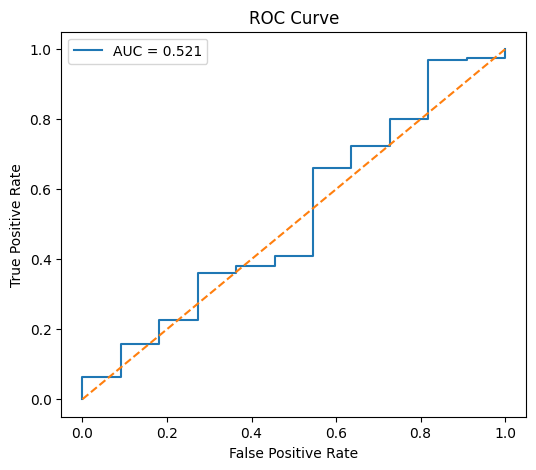

In [33]:
# plot ROC/AUC curve for ResNet18 model
plot_roc(resnet18_model, test_loader)

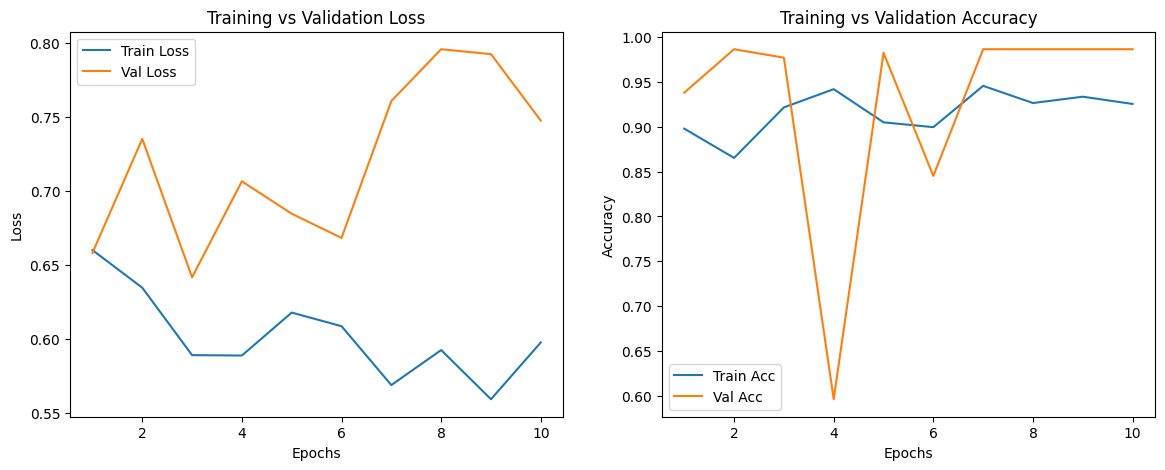

In [34]:
# plot accuracy/loss plots for ResNet18 model
plot_training_curves(history_resnet)


In [35]:

baseline_acc = accuracy_score(y_true, y_pred)
resnet_acc = accuracy_score(y_true_res, y_pred_res)

baseline_f1 = f1_score(y_true, y_pred)
resnet_f1 = f1_score(y_true_res, y_pred_res)

print("Model Comparison:")
print(f"Baseline CNN - Accuracy: {baseline_acc:.4f}, F1: {baseline_f1:.4f}")
print(f"ResNet18     - Accuracy: {resnet_acc:.4f}, F1: {resnet_f1:.4f}")


Model Comparison:
Baseline CNN - Accuracy: 0.9852, F1: 0.9926
ResNet18     - Accuracy: 0.9852, F1: 0.9926


In [ ]:
# it is good to check our models performance against images that were not
# in the dataset.

# function to check non-dataset images against the models
def predict_single_image(
    model,
    image_path,
    transform,
    class_names=["Healthy", "Defect"]
    ):

    # set the model to evaluation mode
    model.eval()

    # load and transform image
    img = Image.open(image_path).convert("RGB")
    img_t = transform(img).unsqueeze(0)  # add batch dimension

    # move the image tensor to the same device the model is using
    img_t = img_t.to(next(model.parameters()).device)

    with torch.no_grad(): # inference without gradient computation
        output = model(img_t) # forward pass
        _, pred = torch.max(output, 1) # predicted class index

    return class_names[pred.item()]


In [ ]:
img_path = "/content/drive/MyDrive/broken_panel.jpg"

In [ ]:
# function to display our non-dataset image
def predict_and_show(model, image_path, transform):
    pred = predict_single_image(model, image_path, transform)

    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Prediction: {pred}")
    plt.axis("off")
    plt.show()


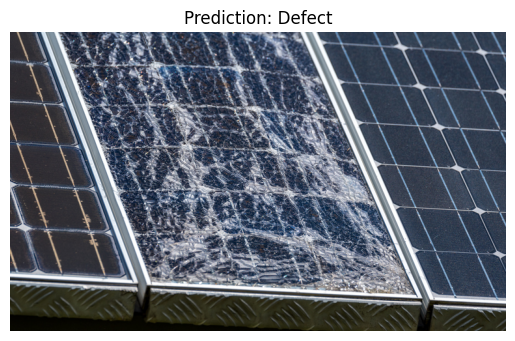

In [ ]:
predict_and_show(resnet18_model, img_path, test_transform)


In [ ]:
# call the prediction function for ResNet18 against our image
prediction = predict_single_image(resnet18_model, img_path, test_transform)
print("Prediction:", prediction)


Prediction: Defect


In [ ]:
# call the predicition function for CNN against our image
predict_single_image(baseline_model, img_path, test_transform)


'Defect'

In [ ]:
img2_path = "/content/drive/MyDrive/dusty_panel.jpg"

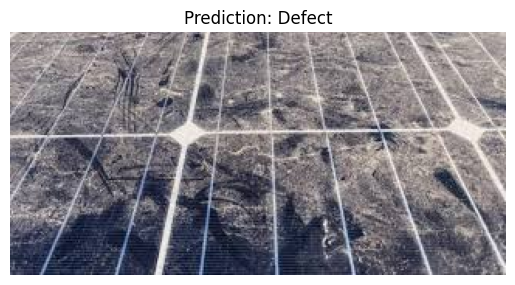

In [ ]:
predict_and_show(resnet18_model, img2_path, test_transform)


In [ ]:
# call the prediction function for ResNet18 against our image
prediction = predict_single_image(resnet18_model, img_path, test_transform)
print("Prediction:", prediction)

Prediction: Defect


In [ ]:
# call the predicition function for CNN against our image
predict_single_image(baseline_model, img_path, test_transform)


'Defect'

### Evaluation and Error Analysis

In [36]:
#function to evaluate model and produce
#accuracy, precision, recall, f1 macro and avg
#conf matrix
def evaluate_model(model, data_loader, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    all_paths = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            #image data extraction
            if isinstance(batch, dict):
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                paths  = batch.get('image_path', [])
            else:
                batch = [b.to(device) if torch.is_tensor(b) else b for b in batch]
                images = batch[0]
                labels = batch[1]
                if len(batch) > 2 and isinstance(batch[2], (list, tuple)):
                    paths = batch[2]
                else:
                    paths = []

            #pass it forward
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            #consolidate result. metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            if isinstance(paths, (list, tuple)):
                all_paths.extend(paths)
            else:
                all_paths.extend([paths] * images.size(0))   # fallback

    #numpy for format and readability
    all_preds  = np.array(all_preds)
    all_labels = np.array(all_labels)

    #compute metrics and print them out
    #visually appealing
    accuracy = accuracy_score(all_labels, all_preds)

    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall    = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1_class  = f1_score(all_labels, all_preds, average=None, zero_division=0)
    f1_macro  = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision  (Non-Defect / Defect): {precision}")
    print(f"Recall     (Non-Defect / Defect): {recall}")
    print(f"F1-class   (Non-Defect / Defect): {f1_class}")
    print(f"Macro F1: {f1_macro:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=['Non-Defect', 'Defect'],
                                digits=4))

    #create confusion metrics and print with plt
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Defect', 'Defect'],
                yticklabels=['Non-Defect', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    #perform detailed error analysis for business applicability
    misclassified_idx = np.where(all_preds != all_labels)[0]
    print(f"\nMisclassified samples: {len(misclassified_idx)} / {len(all_labels)}")

    if all_paths and len(all_paths) == len(all_labels):
        print("\nFirst 5 misclassified image paths:")
        for i in misclassified_idx[:5]:
            print(f"Path: {all_paths[i]} | True: {all_labels[i]} → Pred: {all_preds[i]}")

        #demonstrate where the model went wrong
        print("\nVisualising 3 misclassified examples:")
        for i in misclassified_idx[:3]:
            img = Image.open(all_paths[i])
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"True: {['Non-Defect','Defect'][all_labels[i]]} | "
                      f"Pred: {['Non-Defect','Defect'][all_preds[i]]}")
            plt.axis('off')
            plt.show()
  #return all metrics
    return {
        'accuracy'      : accuracy,
        'precision'     : precision,
        'recall'        : recall,
        'f1_class'      : f1_class,
        'f1_macro'      : f1_macro,
        'confusion_matrix' : cm,
        'misclassified_idx': misclassified_idx,
        'paths'         : all_paths
    }

In [37]:
#function for roc and pr curves
def plot_roc_and_pr_curves(model, data_loader, device=None, model_name="Model"):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.eval()
    model.to(device)

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Probabilities [{model_name}]", leave=False):
            #batch parsing
            if isinstance(batch, dict):
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
            else:
                batch = [b.to(device) if torch.is_tensor(b) else b for b in batch]
                images = batch[0]
                labels = batch[1]

            #pass forward probabilities of pos class
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    #compute ROC AUC metric
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    #computer PR AUC metric
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)

    #plot and display metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    #create and plot AUC ROC
    ax1.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} - ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    #create and plot AUC PR
    ax2.plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AP = {pr_auc:.4f})')
    pos_prevalence = all_labels.mean()
    ax2.axhline(y=pos_prevalence, color='red', linestyle='--',
                label=f'No-skill baseline ({pos_prevalence:.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} - Precision-Recall Curve')
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"{model_name}")
    print(f"   ROC-AUC       : {roc_auc:.4f}")
    print(f"   PR-AUC (AP)   : {pr_auc:.4f}  ← **Primary metric for imbalanced data**")
    print(f"   Positive rate : {pos_prevalence:.4f} ({sum(all_labels)} / {len(all_labels)} defects)\n")

    return roc_auc, pr_auc

In [39]:
#function to provide benchmark computing metrics latency and throughput
def benchmark_model(model, test_loader=None, device=None,
                         batch_size=1, warmup_runs=50, benchmark_runs=300,
                         model_name="Model"):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"\nBenchmarking '{model_name}' on {device} (batch_size={batch_size})")
    model.eval()
    model.to(device)

    #initialize dummy input
    if test_loader is not None:
        try:
            batch = next(iter(test_loader))
            if isinstance(batch, dict):
                dummy_batch = batch['image'].to(device)
            else:
                dummy_batch = batch[0].to(device)
            print(f"   Using real data shape from test_loader: {dummy_batch.shape}")
        except Exception as e:
            print(f"   Could not get batch from loader ({e}), falling back to (224,224)")
            dummy_batch = torch.randn(batch_size, 3, 224, 224, device=device)
    else:
        dummy_batch = torch.randn(batch_size, 3, 224, 224, device=device)

    #resize to mimic real batch
    if dummy_batch.size(0) != batch_size:
        dummy_batch = dummy_batch[:batch_size]

    #get RAM model size metrics
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_ram_mb = (param_size + buffer_size) / (1024**2)

    #get model size on disk to use as backup
    size_disk_mb = None
    try:
        traced = torch.jit.trace(model, dummy_batch[:1])
        with tempfile.NamedTemporaryFile(suffix='.pt', delete=False) as f:
            torch.jit.save(traced, f.name)
            size_disk_mb = os.path.getsize(f.name) / (1024*1024)
        os.unlink(f.name)
    except Exception as e:
        print(f"   TorchScript tracing failed ({e}), using state_dict size instead.")
        with tempfile.NamedTemporaryFile(suffix='.pth', delete=False) as f:
            torch.save(model.state_dict(), f.name)
            size_disk_mb = os.path.getsize(f.name) / (1024*1024)
        os.unlink(f.name)

    #warmup metrics
    with torch.no_grad():
        for _ in range(warmup_runs):
            _ = model(dummy_batch)
        if device.type == 'cuda':
            torch.cuda.synchronize()

    #grab latency benchmark
    timings_ms = []
    with torch.no_grad():
        for _ in tqdm(range(benchmark_runs), desc="Measuring latency", leave=False):
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(dummy_batch)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end = time.perf_counter()
            timings_ms.append((end - start) * 1000)

    avg_latency = np.mean(timings_ms)
    std_latency = np.std(timings_ms)
    throughput = (1000 / avg_latency) * batch_size

    #print and export final report
    print(f"\n{model_name} - complete")
    print("─" * 60)
    print(f"{'Input shape':<20} : {tuple(dummy_batch.shape)}")
    print(f"{'Model Size (RAM)':<20} : {size_ram_mb:6.2f} MB")
    print(f"{'Model Size (Disk)':<20} : {size_disk_mb:6.2f} MB")
    print(f"{'Avg Latency':<20} : {avg_latency:6.3f} ± {std_latency:.3f} ms")
    print(f"{'Throughput':<20} : {throughput:6.2f} img/s (batch={batch_size})")
    print("─" * 60 + "\n")

    return {
        'model_name': model_name,
        'input_shape': tuple(dummy_batch.shape),
        'size_ram_mb': round(size_ram_mb, 3),
        'size_disk_mb': round(size_disk_mb, 3),
        'latency_ms': round(avg_latency, 3),
        'throughput_fps': round(throughput, 2),
        'batch_size': batch_size
    }

Evaluating Baseline CNN:



Accuracy: 0.9852
Precision  (Non-Defect / Defect): [0.         0.98521505]
Recall     (Non-Defect / Defect): [0. 1.]
F1-class   (Non-Defect / Defect): [0.         0.99255247]
Macro F1: 0.4963

Classification Report:
              precision    recall  f1-score   support

  Non-Defect     0.0000    0.0000    0.0000        11
      Defect     0.9852    1.0000    0.9926       733

    accuracy                         0.9852       744
   macro avg     0.4926    0.5000    0.4963       744
weighted avg     0.9706    0.9852    0.9779       744



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


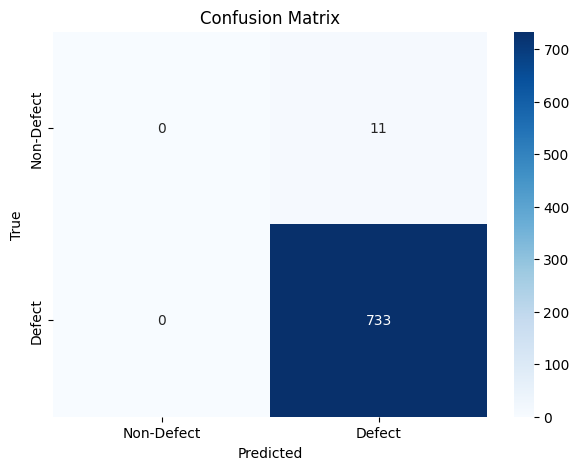


Misclassified samples: 11 / 744

Evaluating ResNet18:



Accuracy: 0.9852
Precision  (Non-Defect / Defect): [0.         0.98521505]
Recall     (Non-Defect / Defect): [0. 1.]
F1-class   (Non-Defect / Defect): [0.         0.99255247]
Macro F1: 0.4963

Classification Report:
              precision    recall  f1-score   support

  Non-Defect     0.0000    0.0000    0.0000        11
      Defect     0.9852    1.0000    0.9926       733

    accuracy                         0.9852       744
   macro avg     0.4926    0.5000    0.4963       744
weighted avg     0.9706    0.9852    0.9779       744



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


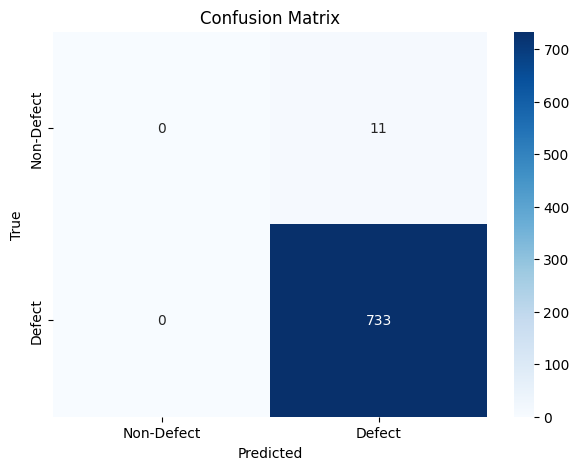


Misclassified samples: 11 / 744


In [40]:
#perform baseline metric analysis
print("Evaluating Baseline CNN:")
baseline_metrics = evaluate_model(baseline_model, test_loader)

print("\nEvaluating ResNet18:")
resnet_metrics = evaluate_model(resnet18_model, test_loader)

auc roc and auc pr curves


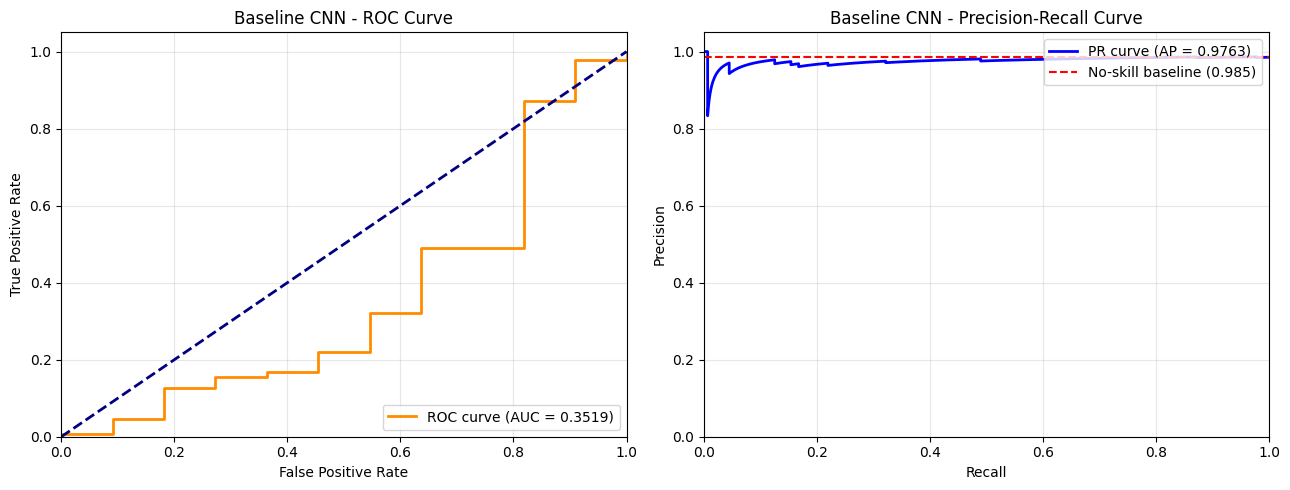

Baseline CNN
   ROC-AUC       : 0.3519
   PR-AUC (AP)   : 0.9763  ← **Primary metric for imbalanced data**
   Positive rate : 0.9852 (733 / 744 defects)



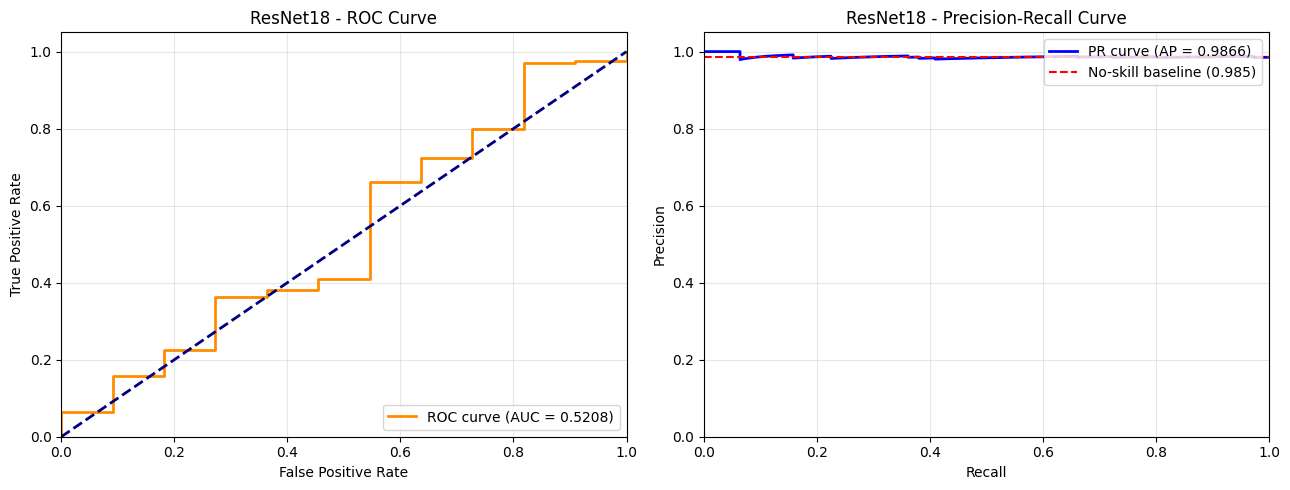

ResNet18
   ROC-AUC       : 0.5208
   PR-AUC (AP)   : 0.9866  ← **Primary metric for imbalanced data**
   Positive rate : 0.9852 (733 / 744 defects)



(np.float64(0.520773905494233), np.float64(0.9866170803825989))

In [43]:
print("="*60)
print("auc roc and auc pr curves")
print("="*60)

#baseline CNN metric curves
plot_roc_and_pr_curves(baseline_model, test_loader, model_name="Baseline CNN")

#resnet18 metric curves
plot_roc_and_pr_curves(resnet18_model, test_loader, model_name="ResNet18")

In [46]:
print("="*70)
print("benchmark business metrics")
print("="*70)

#get CNN benchmark metrics
stats_cnn = benchmark_model(
    baseline_model,
    test_loader=test_loader,
    batch_size=1,
    benchmark_runs=300,
    model_name="Baseline CNN"
)

stats_resnet = benchmark_model(
    resnet18_model,
    test_loader=test_loader,
    batch_size=1,
    benchmark_runs=300,
    model_name="ResNet18 (Fine-tuned)"
)

#summarize and interpret
print("\nDEPLOYMENT COMPARISON")
print("="*80)
print(f"{'Model':<20} {'Size':<10} {'Latency':<12} {'Throughput':<15}")
print("─"*80)
print(f"{'Baseline CNN':<20} {stats_cnn['size_disk_mb']:<10.2f} "
      f"{stats_cnn['latency_ms']:<12.3f} {stats_cnn['throughput_fps']:<15.2f}")
print(f"{'ResNet18':<20} {stats_resnet['size_disk_mb']:<10.2f} "
      f"{stats_resnet['latency_ms']:<12.3f} {stats_resnet['throughput_fps']:<15.2f}")
print("="*80)

benchmark business metrics

Benchmarking 'Baseline CNN' on cuda (batch_size=1)
   Using real data shape from test_loader: torch.Size([32, 3, 256, 256])



Baseline CNN - complete
────────────────────────────────────────────────────────────
Input shape          : (1, 3, 256, 256)
Model Size (RAM)     : 129.49 MB
Model Size (Disk)    : 129.51 MB
Avg Latency          :  1.452 ± 0.176 ms
Throughput           : 688.51 img/s (batch=1)
────────────────────────────────────────────────────────────


Benchmarking 'ResNet18 (Fine-tuned)' on cuda (batch_size=1)


   Using real data shape from test_loader: torch.Size([32, 3, 256, 256])



ResNet18 (Fine-tuned) - complete
────────────────────────────────────────────────────────────
Input shape          : (1, 3, 256, 256)
Model Size (RAM)     :  42.68 MB
Model Size (Disk)    :  42.83 MB
Avg Latency          :  2.947 ± 0.611 ms
Throughput           : 339.36 img/s (batch=1)
────────────────────────────────────────────────────────────


DEPLOYMENT COMPARISON
Model                Size       Latency      Throughput     
────────────────────────────────────────────────────────────────────────────────
Baseline CNN         129.51     1.452        688.51         
ResNet18             42.83      2.947        339.36         


In [ ]:
### The End ###
#please see technical report for detailed analysis and conclusions!